In [2]:
import numpy as np
import random
from functools import reduce
import matplotlib.pyplot as plt
n_qubits = 10
n_layers=1
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Rotation gate around Y-axis
def RY(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ])

#Tensor product 
def kron_n(*ops):
    return reduce(np.kron, ops)
#initial state |000...0⟩
def initial_state(n):
    state = np.zeros(2**n, dtype=complex)
    state[0] = 1.0
    return state
#Construct full CNOT
def get_cnot_matrix(n_qubits, control, target):
    P0 = np.array([[1, 0], [0, 0]])  # |0⟩⟨0|
    P1 = np.array([[0, 0], [0, 1]])  # |1⟩⟨1|
    
    ops_0 = []
    ops_1 = []
    
    for i in range(n_qubits):
        if i == control:
            ops_0.append(P0)
            ops_1.append(P1)
        elif i == target:
            ops_0.append(I)
            ops_1.append(X)
        else:
            ops_0.append(I)
            ops_1.append(I)
    
    term1 = kron_n(*ops_0)
    term2 = kron_n(*ops_1)
    return term1 + term2
#Apply single-qubit gate
def apply_single_qubit_gate(state, gate, target, n_qubits):
    ops = [I] * n_qubits
    ops[target] = gate
    U = kron_n(*ops)
    return U @ state
#Applying CNOT
def apply_cnot(state, control, target, n_qubits):
    U_cnot = get_cnot_matrix(n_qubits, control, target)
    return U_cnot @ state
def hamiltonian(n_qubits, edges, seed):
    np.random.seed(seed)
    weights = np.random.uniform(0.2, 0.8, len(edges))
    
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)

    for (idx, (i, j)) in enumerate(edges):
        ops = [I] * n_qubits
        ops[i] = Z
        ops[j] = Z
        term = weights[idx] * kron_n(*ops)
        H += term

    return H, weights
def print_symbolic_hamiltonian(edges, weights):
    print("H = ", end="")
    terms = []
    for (i, j), w in zip(edges, weights):
        terms.append(f"{w:.3f} * Z[{i}]Z[{j}]")
    print(" + ".join(terms))
def ansatz(theta, n_qubits, edges, n_layers):
    state = initial_state(n_qubits)
    param_idx = 0

    for _ in range(n_layers):
        # Apply RY rotation to each qubit
        for i in range(n_qubits):
            angle = theta[param_idx]
            param_idx += 1
            ry_gate = RY(angle)
            state = apply_single_qubit_gate(state, ry_gate, i, n_qubits)

        # Apply CNOTs based on Hamiltonian structure
        for control, target in edges:
            state = apply_cnot(state, control, target, n_qubits)
    state = state / np.linalg.norm(state)
    return state

def generate_random_edges(n_qubits, n_edges, seed):
    random.seed(seed)
    all_possible_edges = [(i, j) for i in range(n_qubits) for j in range(i + 1, n_qubits)]
    edges = random.sample(all_possible_edges, min(n_edges, len(all_possible_edges)))
    return edges




In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_qubit_connectivity(n_qubits, edges,seed):
    G = nx.Graph()
    G.add_nodes_from(range(n_qubits))
    G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed)  # Force-directed layout
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color='gray', width=2)
    plt.title("Qubit Connectivity Graph (Based on Hamiltonian Edges)")
    plt.show()



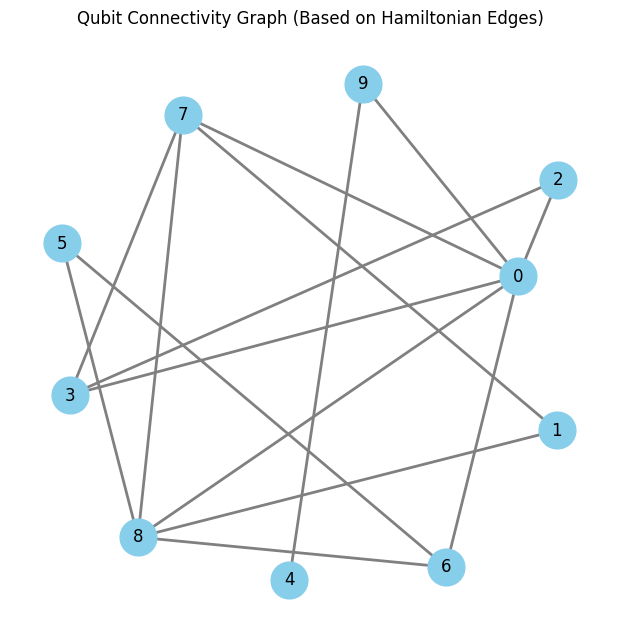

In [11]:
n_qubits = 10
n_edges = 15
seed = 42   
n_layers = 2
pdim=n_layers*n_qubits
edges = generate_random_edges(n_qubits, n_edges, seed)
visualize_qubit_connectivity(n_qubits, edges,seed)


In [12]:
def expectation(theta, H, n_qubits, n_layers):
    psi = ansatz(theta, n_qubits,edges, n_layers)
    return np.real(np.vdot(psi, H @ psi))
H, weights = hamiltonian(n_qubits, edges, seed)
print_symbolic_hamiltonian(edges, weights)
def cost(theta):
    return expectation(theta, H, n_qubits,n_layers)


H = 0.425 * Z[6]Z[8] + 0.770 * Z[0]Z[8] + 0.639 * Z[0]Z[2] + 0.559 * Z[2]Z[3] + 0.294 * Z[1]Z[8] + 0.294 * Z[1]Z[7] + 0.235 * Z[0]Z[9] + 0.720 * Z[0]Z[7] + 0.561 * Z[4]Z[9] + 0.625 * Z[0]Z[6] + 0.212 * Z[3]Z[7] + 0.782 * Z[0]Z[3] + 0.699 * Z[7]Z[8] + 0.327 * Z[5]Z[6] + 0.309 * Z[5]Z[8]


In [23]:
def nelder_mead_with_restarts(f, x_start, step=0.5, tol=1e-6, max_iter=500,
                              check_last=2, restart_thresh=1e-5, max_restarts=500):
    n = len(x_start)
    x_current = np.array(x_start)
    total_iterations = 0
    f_history_total = []
    itr = 1
    for restart in range(max_restarts):
        # Initialize simplex
        simplex = [x_current]
        for i in range(n):
            x = np.array(x_current, dtype=float)
            x[i] += step
            simplex.append(x)
        simplex = np.array(simplex)
        
        f_history = []
        for iteration in range(max_iter):
            simplex = sorted(simplex, key=f)
            f_values = [f(x) for x in simplex]

            f_history.append(f_values[0])
            f_history_total.append(f_values[0])
            total_iterations += 1
            # Check convergence by std
            if np.std(f_values) < tol:
                return simplex[0], f_values[0], total_iterations, f_history_total

            # Check if function is stagnating
            if len(f_history) > check_last:
                recent_changes = np.abs(np.diff(f_history[-check_last:]))
                if np.max(recent_changes) < restart_thresh:
                    print(f"🔁 Restarting after stagnation at restart #{restart + 1}")
                    x_current = simplex[0]  # restart from current best
                    break  # Exit to outer loop to restart Nelder-Mead

            # Compute centroid (excluding worst point)
            centroid = np.mean(simplex[:-1], axis=0)

            # Reflection
            xr = centroid + (centroid - simplex[-1])
            fr = f(xr)

            if f_values[0] <= fr < f_values[-2]:
                simplex[-1] = xr
            elif fr < f_values[0]:
                xe = centroid + 2 * (xr - centroid)
                fe = f(xe)
                simplex[-1] = xe if fe < fr else xr
            else:
                xc1 = simplex[-1] + 0.25 * (xr - simplex[-1])
                xc3 = simplex[-1] + 0.75 * (xr - simplex[-1])
                fc1 = f(xc1)
                fc3 = f(xc3)
                if fc1 < fc3:
                    xc, fc = xc1, fc1
                else:
                    xc, fc = xc3, fc3
                if fc < f_values[-1]:
                    simplex[-1] = xc
                else:
                    for i in range(1, len(simplex)):
                        simplex[i] = simplex[0] + 0.5 * (simplex[i] - simplex[0])
            
            print(f"Iteration {itr}, Best Value: {f_values[0]:.6f}")
            itr += 1
        else:
            # If we finish all iterations without stagnation, return best found
            return simplex[0], f(simplex[0]), total_iterations, f_history_total
    
    # If all restarts are exhausted
    return simplex[0], f(simplex[0]), total_iterations, f_history_total


In [24]:
x0 = np.random.uniform(0, 2 * np.pi, pdim)
sol, fval, iters, histo = nelder_mead_with_restarts(cost, x0)

print("[Nelder-Mead] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", fval)
print("[Nelder-Mead] Optimal θ:", sol)
print("[Nelder-Mead] Total Iterations:", iters)


Iteration 1, Best Value: -0.306160
Iteration 2, Best Value: -0.614275
🔁 Restarting after stagnation at restart #1
Iteration 3, Best Value: -0.739356
Iteration 4, Best Value: -0.739356
Iteration 5, Best Value: -0.855381
🔁 Restarting after stagnation at restart #2
Iteration 6, Best Value: -0.988189
Iteration 7, Best Value: -0.988189
🔁 Restarting after stagnation at restart #3
Iteration 8, Best Value: -1.146235
Iteration 9, Best Value: -1.146235
🔁 Restarting after stagnation at restart #4
Iteration 10, Best Value: -1.306173
Iteration 11, Best Value: -1.306173
Iteration 12, Best Value: -1.436910
🔁 Restarting after stagnation at restart #5
Iteration 13, Best Value: -1.630888
Iteration 14, Best Value: -1.630888
🔁 Restarting after stagnation at restart #6
Iteration 15, Best Value: -1.731197
Iteration 16, Best Value: -1.731197
🔁 Restarting after stagnation at restart #7
Iteration 17, Best Value: -1.803277
Iteration 18, Best Value: -1.803277
🔁 Restarting after stagnation at restart #8
Iteration

KeyboardInterrupt: 